# Gyakorlat 07
## Neurális hálózatok tanítása

### Kézzel írott számok III
Ebben a feladatban tanítani fogjuk a neurális hálózatunkat, hogy az képes legyen felismerni kézzel írott számokat (0-9).

### 1: Importáljuk be a használni kívánt csomagokt és az adatokat olvassuk be

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

data = loadmat("Lab7data.mat")                      # adatok beolvasása
X = data["X"]
Y = data ["y"]                                      # adatok elrendezése
del data
m = X.shape[0]
print('Shape of X and Y in order:')
print(X.shape)
print(Y.shape)

data = loadmat("Lab7Weights.mat")                   # súlyok beolvasása
w1 = np.array(data["Theta1"])
w2 = np.array(data["Theta2"])                       # súlyok elrendezése
print('Shape of w1 and w2 in order:')
print(w1.shape)
print(w2.shape)
del data

Shape of X and Y in order:
(5000, 400)
(5000, 1)
Shape of w1 and w2 in order:
(25, 401)
(10, 26)


### 2: Adatok vizualizálása

Printing some random data ...


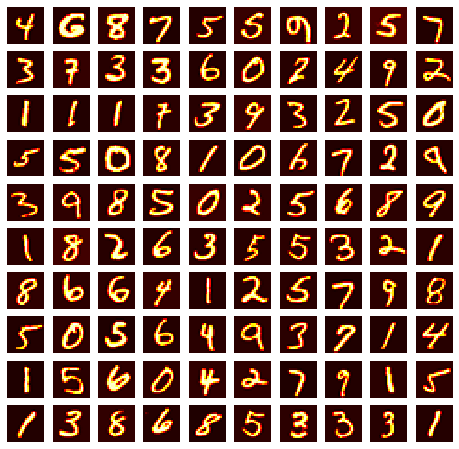

In [4]:
print("Printing some random data ...")                              
fig, ax = plt.subplots(10,10, figsize =(8,8))                  # subplots - 10x10 8x8as képnagysággal
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X[np.random.randint(0,m+1),:].reshape(20,20, order = "F"), cmap="hot")
        ax[i,j].axis("off")
plt.show()

### 3: adatok előkészítése a neurális hálózatokhoz

In [5]:
Lambda = 1                                   
input_layer_size = 400                                  # bemeneti réteg nagysága
hidden_layer_size = 25                                  # rejtett réteg nagysága
num_labels = 10                                         # labelek száma
nn_params = np.append(w1.flatten(), w2.flatten())       # kialapítjuk a w1 és w2-t és egymás után füzzük

### 4: Költségfüggvény neurális hálózat változata

In [8]:
def sigmoid(z):
    return 1/(1+(np.exp(-z)))

def sigmoidGradient(z):
    return sigmoid(z) * (1-sigmoid(z))

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
    nn_params contains the parameters unrolled into a vector

    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    w1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size + 1)
    w2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size + 1)

    m = X.shape[0]
    J = 0
    X = np.hstack((np.ones((m, 1)), X))
    y10 = np.zeros((m, num_labels))

    a1 = sigmoid(X @ w1.T)
    a1 = np.hstack((np.ones((m, 1)), a1))                                # hidden layer
    a2 = sigmoid(a1 @ w2.T)                                              # output layer

    for i in range(1, num_labels + 1):
        y10[:, i - 1][:, np.newaxis] = np.where(y == i, 1, 0)
    for j in range(num_labels):
        J = J + sum(-y10[:, j] * np.log(a2[:, j]) - (1 - y10[:, j]) * np.log(1 - a2[:, j]))

    cost = 1 / m * J
    reg_J = cost + Lambda / (2 * m) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    # Implement the backpropagation algorithm to compute the gradients

    grad1 = np.zeros((w1.shape))
    grad2 = np.zeros((w2.shape))

    for i in range(m):
        xi = X[i, :]                                        # 1 X 401
        a1i = a1[i, :]                                      # 1 X 26
        a2i = a2[i, :]                                      # 1 X 10
        d2 = a2i - y10[i, :]
        d1 = w2.T @ d2.T * sigmoidGradient(np.hstack((1, xi @ w1.T)))
        grad1 = grad1 + d1[1:][:, np.newaxis] @ xi[:, np.newaxis].T
        grad2 = grad2 + d2.T[:, np.newaxis] @ a1i[:, np.newaxis].T

    grad1 = 1 / m * grad1
    grad2 = 1 / m * grad2

    grad1_reg = grad1 + (Lambda / m) * np.hstack((np.zeros((w1.shape[0], 1)), w1[:, 1:]))
    grad2_reg = grad2 + (Lambda / m) * np.hstack((np.zeros((w2.shape[0], 1)), w2[:, 1:]))

    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg


C, reg_C = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,Y,Lambda)[0:4:3]
print("Cost at parameters (non-regularized):",C,"\nCost at parameters (Regularized):",reg_C)

Cost at parameters (non-regularized): 0.28762916516131876 
Cost at parameters (Regularized): 0.3837698590909235


### 5: Kezdeti súlyok

In [10]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12

    W = np.random.rand(L_out,L_in+1)*(2*epsilon_init)-epsilon_init

    return W

initial_w1 = randInitializeWeights(input_layer_size,hidden_layer_size)
initial_w2 = randInitializeWeights(hidden_layer_size,num_labels)
initial_nn_params = np.append(initial_w1.flatten(),initial_w2.flatten())

### 6: Grádiens módszer

In [34]:
def gradientDescentnn(X, y, initial_nn_params, alpha, num_iters, Lambda, input_layer_size, hidden_layer_size,
                      num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha

    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size,
                                                                                      input_layer_size + 1)
    Theta2 = initial_nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size + 1)

    m = len(y)
    C_history = []

    for i in range(num_iters):
        if (i%20==0):
            print('Iteration:', i+1)
        elif (i==num_iters-1):
            print('Done!')
        nn_params = np.append(Theta1.flatten(), Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[
                             3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        C_history.append(cost)

    nn_paramsFinal = np.append(Theta1.flatten(), Theta2.flatten())
    return nn_paramsFinal, C_history


nnw, nnC_history = gradientDescentnn(X,Y,initial_nn_params,0.8,800,1,input_layer_size,hidden_layer_size,num_labels)
w1 = nnw[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
w2 = nnw[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Iteration: 1
Iteration: 21
Iteration: 41
Iteration: 61
Iteration: 81
Iteration: 101
Iteration: 121
Iteration: 141
Iteration: 161
Iteration: 181
Iteration: 201
Iteration: 221
Iteration: 241
Iteration: 261
Iteration: 281
Iteration: 301
Iteration: 321
Iteration: 341
Iteration: 361
Iteration: 381
Iteration: 401
Iteration: 421
Iteration: 441
Iteration: 461
Iteration: 481
Iteration: 501
Iteration: 521
Iteration: 541
Iteration: 561
Iteration: 581
Iteration: 601
Iteration: 621
Iteration: 641
Iteration: 661
Iteration: 681
Iteration: 701
Iteration: 721
Iteration: 741
Iteration: 761
Iteration: 781
Done!


Nem futtatjuk végig, csak egy nagyon kicsi részen, hogy lehessen látni mennyire lassú az általunk megírt nem optimalizált kód.... a kész eredményeket betöltjük inkább a következő cellában. Otthon ki lehet próbálni 800 iterációra hogy ugyanazt adja e ki...

In [36]:
def predict(w1,w2,X):
    m = X.shape[0]

    a1 = np.column_stack((np.ones((m,1)),X))
    z2 = a1 @ w1.T
    a2 = np.column_stack((np.ones((m,1)),sigmoid(z2)))
    z3 = a2 @ w2.T
    a3 = sigmoid(z3)

    return np.argmax(a3,axis=1)+1

def accuracy(pred,Y):
    return (np.sum(pred[:,np.newaxis]==Y)/5000)*100

w1_r = np.loadtxt("w1_final.txt")
w2_r = np.loadtxt("w2_final.txt")

pred3 = predict(w1_r,w2_r,X)
acc = accuracy(pred3,Y)
print('Training Set Accuracy:',acc,'%')

Training Set Accuracy: 94.36 %


### 7: Költségfüggvény az iterációk során

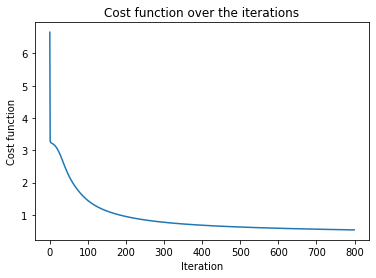

In [46]:
nnC_history=np.loadtxt("nnC_history_800.txt")
plt.plot(nnC_history)
plt.xlabel('Iteration')
plt.ylabel('Cost function')
plt.title('Cost function over the iterations')
plt.show()